This is an exploratory study to check the possibilities to identify phishing, malware or defaced pages only looking at the URL string.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#------- READING THE DATA -------
data = pd.read_csv('malicious_phish.csv')
#https://www.kaggle.com/sid321axn/malicious-urls-dataset

The data was obtained from kaggle: https://www.kaggle.com/sid321axn/malicious-urls-dataset

In [3]:
data.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


The data has only 2 columns, the url string and the type of the page, which can be:

In [4]:
data['type'].value_counts()

benign        428103
defacement     96457
phishing       94111
malware        32520
Name: type, dtype: int64

So we have a data set with 4 classes of pages. What we can try to do is look at the characteristics of each URL and check if there are similar patterns within the classes. One of the characteristic of URLs that we could take a look is the lenght of the URL.

In [5]:
data['urlLen'] = data['url'].apply(lambda x: len(x))

In [6]:
data['urlLen'].value_counts()

31      19023
33      14209
34      12243
27      11967
35      11700
        ...  
710         1
1016        1
452         1
1779        1
467         1
Name: urlLen, Length: 549, dtype: int64

There are some length outliers that we should explore, let's take a look at these huge strings

In [9]:
data[data['urlLen'] > 1000]

,url,type,urlLen
44224,https://lastpass.com/signup2.php?ac=1&from_uri...,benign,1517
62378,https://lastpass.com/signup2.php?ac=1&from_uri...,benign,1189
105506,apps.facebook.com/ajax/emu/end.php?eid=AQLKVXC...,benign,1025
199338,https://lastpass.com/signup2.php?ac=1&from_uri...,benign,1348
293888,https://lastpass.com/signup2.php?ac=1&from_uri...,benign,1040
337711,https://lastpass.com/signup2.php?ac=1&from_uri...,benign,1696
457891,https://asana.com/guide/videos/%22//fast.wisti...,benign,2081
522782,https://nkfmwefiofjwefiwofjweiofwmejfowejfowfw...,phishing,1779
523440,http://integrityozonesolutions.com/chase/Chase...,phishing,1016
524316,http://licogi18.com.vn/login.microsoftonline.c...,phishing,1386


Although very long strings, they are not problematic URLs. 15 of them are benign and 7 are phishing. The smaller ones between 500-1000 letters are also good to go. What about the smaller?

In [13]:
data[data['urlLen'] < 6]

,url,type,urlLen
374391,1b.yt,phishing,5
573423,¾5092,phishing,5
573437,,phishing,1
573446,½4+,phishing,4
573449,=Â-,phishing,5
573468,ºE,phishing,2
573471,WY,phishing,2
573485,)-,phishing,5


In [14]:
data = data.loc[data['urlLen'] > 5]

Let's start to parse the URL strings into features. The URL length is not a good feature since some of the URLs contain a protocol and some don't. Also, some strings have the "www." and some don't and that does will modify the length. 

In [16]:
data['protocol'] = data['url'].apply(lambda x: x.split('://')[0] if len(x.split('://')) > 1 else "No Protocol")

In [17]:
data['protocol'].value_counts()

No Protocol                                                                                                      463172
http                                                                                                             172317
https                                                                                                             15680
ftp                                                                                                                   2
serviceinformation.pakfreewebs.com/verifier/etap1.html?u=xhxxp                                                        2
cristina-sanchez.netne.net/good/etap1.html?u=xhxxp                                                                    2
serviceinformation.pakfreewebs.com/verifier/etap1.html?amp;ct=&amp;u=xhxxp                                            1
brehautfinancial.com/eBayISAPI.php?signin.ebay.co.uk/ws/eBayISAPI.dll?SignIn&ru=file                                  1
www.anita-gd.com/images/?us.battle.net/l

Some urls have a "://" but in the path, as redirecting or referencing to another url. Let's took that into account when separating protocols:

In [18]:
data['protocol'] = data['url'].apply(lambda x: x.split('://')[0] if len(x.split('://')) > 1 and len(x.split('://')[0]) < 6 else "No Protocol")

In [19]:
data['protocol'].value_counts()

No Protocol    463184
http           172317
https           15680
ftp                 2
Name: protocol, dtype: int64

In [20]:
data['nProtocol'] = data['protocol'].apply(lambda x: 1 if x == "http" else 2 if x == "https" else 3 if x == "ftp" else 0)

In [21]:
data['nProtocol'].value_counts()

0    463184
1    172317
2     15680
3         2
Name: nProtocol, dtype: int64

The next part involves identify and parse the url to obtain domain, subdomain, path and so on. This could be easily done by using functions to identify the patterns on the dataframe url strings (such as ://, www., /, ...) but there is already a library which does that for us, check https://pypi.org/project/tld/ for more:

In [25]:
pip install tld

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 412 kB 2.1 MB/s            
Note: you may need to restart the kernel to use updated packages.


In [26]:
from tld import get_tld

In [42]:
data['topLevDomain'] = data['url'].apply(lambda x: get_tld(x,fail_silently=True))

In [43]:
data['topLevDomain'].value_counts()

com       71690
de        11331
net        9903
nl         6157
com.br     5925
          ...  
gov.sa        1
tn            1
click         1
gt            1
ht            1
Name: topLevDomain, Length: 538, dtype: int64

In [44]:
data['tldLen'] = data['topLevDomain'].apply(lambda x: len(x))

TypeError: object of type 'NoneType' has no len()

Ops, it seems that sometimes the output could not be accessed as len, so let's use another strategy:

In [45]:
data['tldLen'] = data['topLevDomain'].apply(lambda x: len(x) if type(x) == str else 0)

In [46]:
data['tldLen']

0         0
1         0
2         0
3         2
4         3
         ..
651186    0
651187    0
651188    0
651189    0
651190    0
Name: tldLen, Length: 651183, dtype: int64

In [47]:
data['tldLen'].value_counts()

0     475273
3      87519
2      58686
6      16601
5       6203
4       5405
12       455
14       307
7        249
9        130
11       121
16        71
15        52
8         50
10        12
13        12
17         9
26         8
20         3
30         3
31         2
21         2
39         2
22         2
25         2
18         2
34         1
27         1
Name: tldLen, dtype: int64

In [57]:
data[data['tldLen'] > 20][['url','topLevDomain']]

,url,topLevDomain
35010,http://bancaribe-ve-lb-1328493527.us-east-1.el...,us-east-1.elb.amazonaws.com
42118,http://www.gfdsr654ree.is-a-financialadvisor.c...,is-a-financialadvisor.com
103639,http://www.asy645reds.boldlygoingnowhere.org/w...,boldlygoingnowhere.org
224975,http://s3-eu-west-1.amazonaws.com/video.00aa42...,s3-eu-west-1.amazonaws.com
242248,http://www.gfdsr654ree.is-a-financialadvisor.c...,is-a-financialadvisor.com
458348,http://masterlink.s3-website-us-east-1.amazona...,s3-website-us-east-1.amazonaws.com
464949,http://www.asy645reds.boldlygoingnowhere.org/w...,boldlygoingnowhere.org
521535,http://autenticasuporte-appitacardrevalidacao-...,sa-east-1.elasticbeanstalk.com
521536,http://autenticasuporte-appitacardrevalidacao-...,sa-east-1.elasticbeanstalk.com
521537,http://autenticasuporte-appitacardrevalidacao-...,sa-east-1.elasticbeanstalk.com


The tld seems to lost some of the words agains the .com or .net. Let's continue to extract the other parts of the url:

In [91]:
def getFLD(url):
    urlObj = get_tld(url, fail_silently=True, as_object = True)

    fld = ""
    try:
        fld = urlObj.fld
    except:
        fld = ""
    
    return fld
data['fullLevDomain'] = data['url'].apply(lambda x: getFLD(x))

In [92]:
def getDomain(url):
    urlObj = get_tld(url, fail_silently=True, as_object = True)
    
    domain = ""
    try:
        domain = urlObj.domain
    except:
        domain = ""
    
    return domain
data['domain'] = data['url'].apply(lambda x: getDomain(x))

In [105]:
def getSubdomain(url):
    urlObj = get_tld(url, fail_silently=True, as_object = True)

    subdomain = ""
    try:
        subdomain = urlObj.subdomain
    except:
        subdomain = ""
    
    return subdomain
data['subdomain'] = data['url'].apply(lambda x: getSubdomain(x))

In [106]:
data['fldLen'] = data['fullLevDomain'].apply(lambda x: len(x))

In [107]:
data['domainLen'] = data['domain'].apply(lambda x: len(x))

In [108]:
data['subdomainLen'] = data['subdomain'].apply(lambda x: len(x))

In [109]:
data['pathVector'] = data['url'].apply(lambda x: x.split('://')[-1].split('/'))

In [110]:
def mergePathVec(text):
    tLen = len(text)
    mergedText = ""
    for i in range (1,tLen):
        if i != 1:
            mergedText += "/"
        mergedText += text[i]
    return mergedText

In [111]:
data['path'] = data['pathVector'].apply(mergePathVec)

In [112]:
data['path']

0                                                          
1                                   music/krizz_kaliko.html
2                                          rexroth/cr/1.htm
3         index.php?option=com_content&view=article&id=7...
4         index.php?option=com_mailto&tmpl=component&lin...
                                ...                        
651186                              objects/850/850402.html
651187                            xbox-360/1860/Dead-Space/
651188                            xbox360/action/deadspace/
651189                         wiki/Dead_Space_(video_game)
651190                              goth/devilmaycrytonite/
Name: path, Length: 651183, dtype: object

In [113]:
data['domain'].value_counts()

                             475273
9779                           3984
mixh                           2886
torcache                       1367
olx                            1314
                              ...  
recome                            1
geotecnologia                     1
comoeliminardolordecabeza         1
ambikadrivingschool               1
imatechwiring                     1
Name: domain, Length: 13930, dtype: int64

In [114]:
data['subdomain'].value_counts()

                                562301
www                              76023
mitsui-jyuku                      2879
onedrive                           321
docs                               275
                                 ...  
dqx.jp.sx                            1
promocao-comprapremiadacielo         1
ice-cheer                            1
alipay-shengji                       1
transvale                            1
Name: subdomain, Length: 3410, dtype: int64

In [115]:
data['pathLen'] = data['path'].apply(lambda x: len(x))

There are other features that can be added here not only taking into account the length of the parsed url. We can look at features such as: number of letters, number of numbers, number of slashes /, number of dots ., number of parameters &, number of fragments #, number of upper and lower case letters and others. Let's filter the URL to avoid including the 'http(s)' and 'www.' in the length of the url when counting each number of features studied, since they are not important and will mess the counting. 

In [120]:
data['filteredURL'] = data['url'].apply(lambda x: x.split('://')[0] if len(x.split('://')) < 2 else x.split('://')[1])

In [124]:
def filterWWW(url):
    if len(url) < 4:
        return url
    if (url[0] == 'w' and url[1] == 'w' and url[2] == 'w' and url[3] == '.'):
        return url[4:]
    else:
        return url
data['filteredURLwww'] = data['filteredURL'].apply(filterWWW)

In [125]:
data[['url','filteredURL','filteredURLwww']]

,url,filteredURL,filteredURLwww
0,br-icloud.com.br,br-icloud.com.br,br-icloud.com.br
1,mp3raid.com/music/krizz_kaliko.html,mp3raid.com/music/krizz_kaliko.html,mp3raid.com/music/krizz_kaliko.html
2,bopsecrets.org/rexroth/cr/1.htm,bopsecrets.org/rexroth/cr/1.htm,bopsecrets.org/rexroth/cr/1.htm
3,http://www.garage-pirenne.be/index.php?option=...,www.garage-pirenne.be/index.php?option=com_con...,garage-pirenne.be/index.php?option=com_content...
4,http://adventure-nicaragua.net/index.php?optio...,adventure-nicaragua.net/index.php?option=com_m...,adventure-nicaragua.net/index.php?option=com_m...
...,...,...,...
651186,xbox360.ign.com/objects/850/850402.html,xbox360.ign.com/objects/850/850402.html,xbox360.ign.com/objects/850/850402.html
651187,games.teamxbox.com/xbox-360/1860/Dead-Space/,games.teamxbox.com/xbox-360/1860/Dead-Space/,games.teamxbox.com/xbox-360/1860/Dead-Space/
651188,www.gamespot.com/xbox360/action/deadspace/,www.gamespot.com/xbox360/action/deadspace/,gamespot.com/xbox360/action/deadspace/
651189,en.wikipedia.org/wiki/Dead_Space_(video_game),en.wikipedia.org/wiki/Dead_Space_(video_game),en.wikipedia.org/wiki/Dead_Space_(video_game)


In [130]:
def countLetters(url):
    n = 0
    for l in url:
        if l.isalpha():
            n += 1
    return n

def countNumbers(url):
    n = 0
    for l in url:
        if l.isdigit():
            n += 1
    return n

def countSlashes(url):
    n = 0
    for l in url:
        if l == '/':
            n += 1
    return n

def countDots(url):
    n = 0
    for l in url:
        if l == '.':
            n += 1
    return n

def countParameters(url):
    n = 0
    for l in url:
        if l == '&':
            n += 1
    return n

def countFragments(url):
    n = 0
    for l in url:
        if l == '#':
            n += 1
    return n

def countPercents(url):
    n = 0
    for l in url:
        if l == '%':
            n += 1
    return n

def countUpper(url):
    n = 0
    for l in url:
        if l.isupper():
            n += 1
    return n

def countLower(url):
    n = 0
    for l in url:
        if l.islower():
            n += 1
    return n

data['nLetters'] = data['filteredURLwww'].apply(countLetters)
data['nNumbers'] = data['filteredURLwww'].apply(countNumbers)
data['nSlashes'] = data['filteredURLwww'].apply(countSlashes)
data['nDots'] = data['filteredURLwww'].apply(countDots)
data['nPars'] = data['filteredURLwww'].apply(countParameters)
data['nFrag'] = data['filteredURLwww'].apply(countFragments)
data['nPercent'] = data['filteredURLwww'].apply(countPercents)
data['nUpper'] = data['filteredURLwww'].apply(countUpper)
data['nLower'] = data['filteredURLwww'].apply(countLower)

In [131]:
data['length'] = data['filteredURLwww'].apply(lambda x: len(x))

In [137]:
data['fullLevDomain'] = data['url'].apply(lambda x: getFLD(x))
data['domain'] = data['url'].apply(lambda x: getDomain(x))
data['subdomain'] = data['url'].apply(lambda x: getSubdomain(x))
data['fldLen'] = data['url'].apply(lambda x: len(x))
data['domainLen'] = data['url'].apply(lambda x: len(x))
data['subdomainLen'] = data['url'].apply(lambda x: len(x))

After extracting a lot of features we can start taking a look at their information and shapes

Text(0.5, 1.0, 'Path Length')

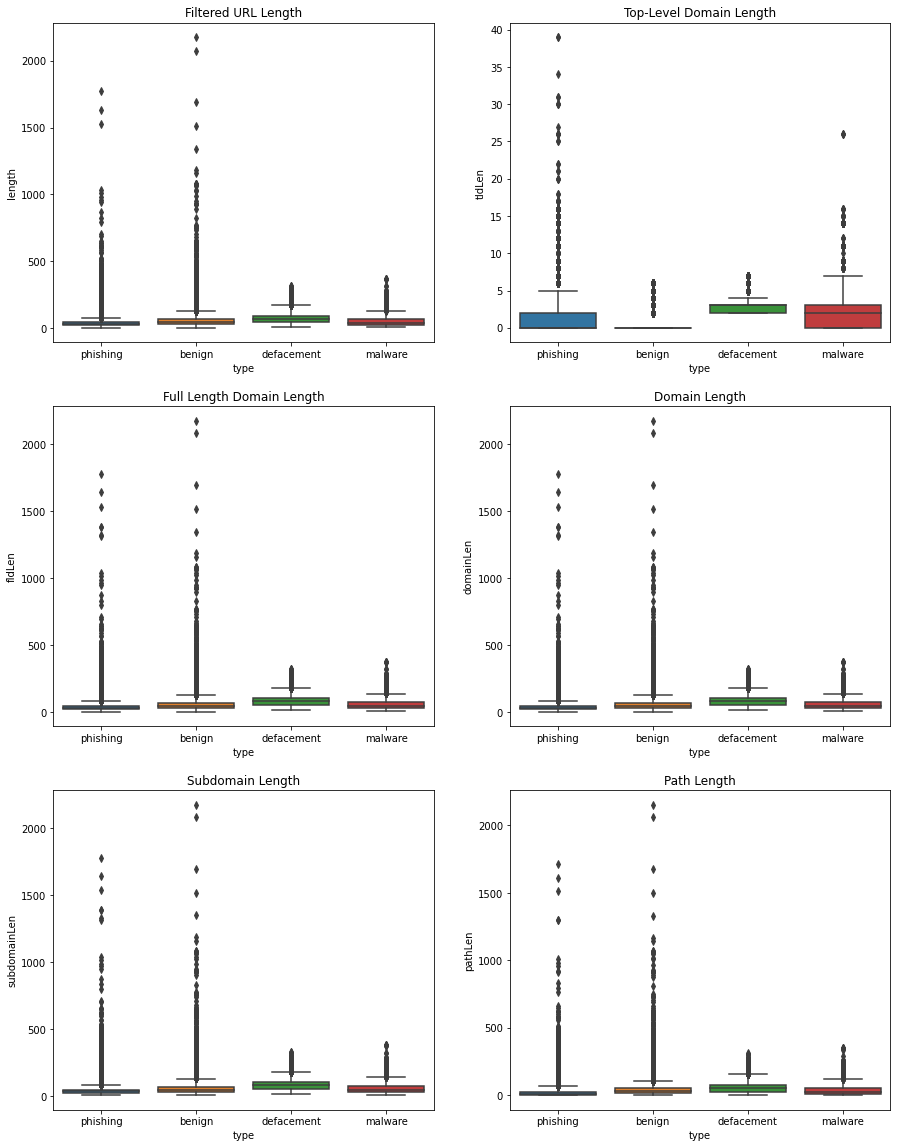

In [141]:
fig, axes = plt.subplots(3,2, figsize=(15, 20), sharey=False)
sns.boxplot(ax=axes[0, 0], x='type', y='length', data=data)
axes[0, 0].set_title('Filtered URL Length')
sns.boxplot(ax=axes[0, 1], x='type', y='tldLen', data=data)
axes[0, 1].set_title('Top-Level Domain Length')
sns.boxplot(ax=axes[1, 0], x='type', y='fldLen', data=data)
axes[1, 0].set_title('Full Length Domain Length')
sns.boxplot(ax=axes[1, 1], x='type', y='domainLen', data=data)
axes[1, 1].set_title('Domain Length')
sns.boxplot(ax=axes[2, 0], x='type', y='subdomainLen', data=data)
axes[2, 0].set_title('Subdomain Length')
sns.boxplot(ax=axes[2, 1], x='type', y='pathLen', data=data)
axes[2, 1].set_title('Path Length')

Some distributions are very different for each type or url, but in general defacement have a longer length in all attributes. Also, the Top-Level Domain length show a very different behaviour between benign urls and the malicious ones.

Text(0.5, 1.0, '# Lower case')

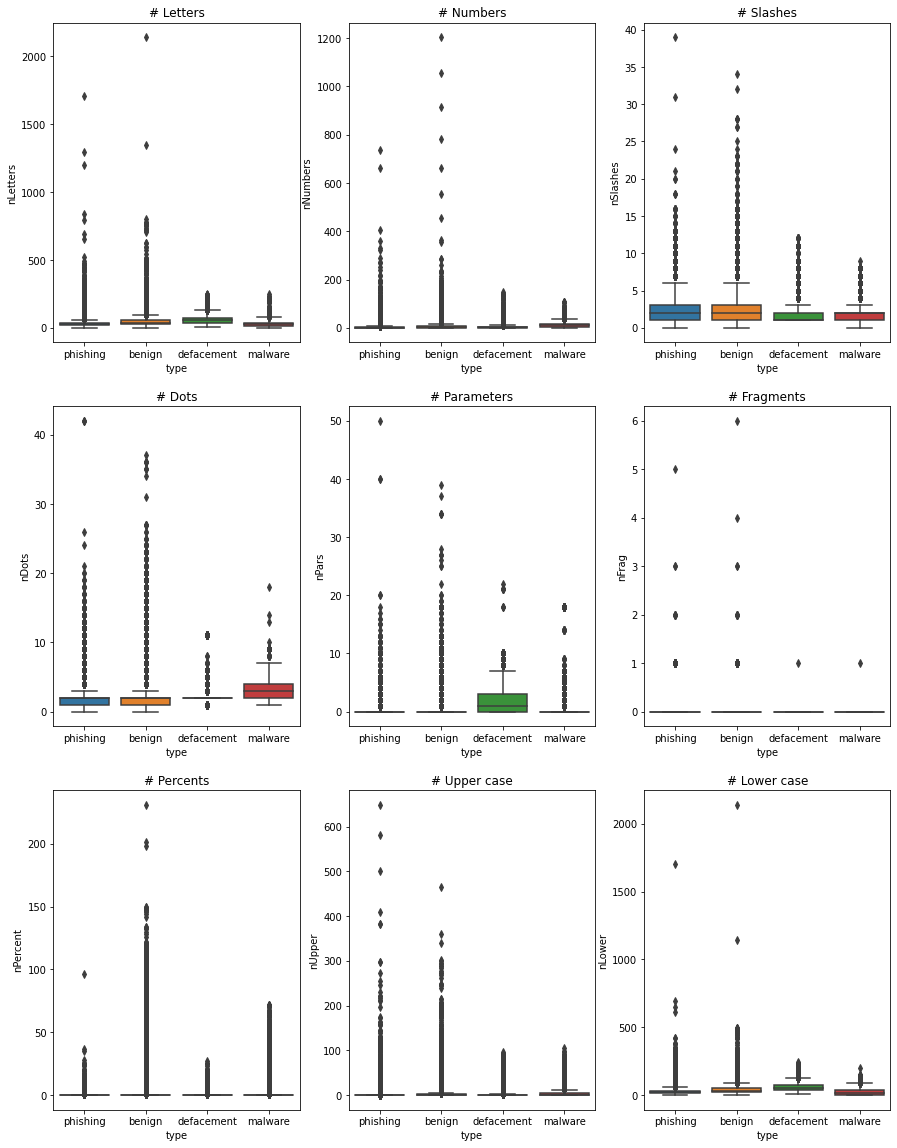

In [143]:
fig, axes = plt.subplots(3,3, figsize=(15, 20), sharey=False)
sns.boxplot(ax=axes[0, 0], x='type', y='nLetters', data=data)
axes[0, 0].set_title('# Letters')
sns.boxplot(ax=axes[0, 1], x='type', y='nNumbers', data=data)
axes[0, 1].set_title('# Numbers')
sns.boxplot(ax=axes[0, 2], x='type', y='nSlashes', data=data)
axes[0, 2].set_title('# Slashes')
sns.boxplot(ax=axes[1, 0], x='type', y='nDots', data=data)
axes[1, 0].set_title('# Dots')
sns.boxplot(ax=axes[1, 1], x='type', y='nPars', data=data)
axes[1, 1].set_title('# Parameters')
sns.boxplot(ax=axes[1, 2], x='type', y='nFrag', data=data)
axes[1, 2].set_title('# Fragments')
sns.boxplot(ax=axes[2, 0], x='type', y='nPercent', data=data)
axes[2, 0].set_title('# Percents')
sns.boxplot(ax=axes[2, 1], x='type', y='nUpper', data=data)
axes[2, 1].set_title('# Upper case')
sns.boxplot(ax=axes[2, 2], x='type', y='nLower', data=data)
axes[2, 2].set_title('# Lower case')

Malwares seems to clearly have a greater number of dots and numbers in their urls. Let's use these parameters to train a decision tree model

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

In [153]:
y = data['type']
x = data[['length','tldLen','fldLen','domainLen','subdomainLen','pathLen','nLetters',
          'nNumbers','nSlashes','nDots','nPars','nFrag','nPercent','nUpper','nLower']]

x_Train,x_t,y_Train,y_t = train_test_split(x,y,test_size=0.3,random_state=1)

In [155]:
treeModel = DecisionTreeClassifier()
treeModel.fit(x_Train, y_Train)
pred = treeModel.predict(x_t)

print('METRICS:')
print(metrics.classification_report(y_t,pred))
confMat = metrics.confusion_matrix(y_t,pred)
print("Confusion Matrix:")
print(confMat)           
print("Confusion Matrix (%):")
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
print(confMat/confMat.astype(float).sum(axis=1,keepdims=True))

METRICS:
              precision    recall  f1-score   support

      benign       0.97      0.97      0.97    128451
  defacement       0.96      0.96      0.96     28920
     malware       0.93      0.94      0.94      9647
    phishing       0.85      0.81      0.83     28337

    accuracy                           0.95    195355
   macro avg       0.93      0.92      0.92    195355
weighted avg       0.95      0.95      0.95    195355

Confusion Matrix:
[[125022    182    116   3131]
 [   203  27875    191    651]
 [    57    131   9050    409]
 [  4093    969    344  22931]]
Confusion Matrix (%):
[[0.973 0.001 0.001 0.024]
 [0.007 0.964 0.007 0.023]
 [0.006 0.014 0.938 0.042]
 [0.144 0.034 0.012 0.809]]


The trained model could differentiate the three classes in a very good way:
1) The benign urls were identified correctly in 97.3% of the cases, being more similar to the phishing in 2.4% of the cases
2) The defacment urls were identified correctly in 96.4% of the cases and only 0.7% would have been identified as benign (which is the worst case scenario: not blocking a malicious url independently of the class)
3) The malware urls were identified correctly in 93.8% of the cases and only 0.6% would have been identified as benign
4) The phishing urls were identified correctly in 80.9% of the cases and in this case 14.4% were wrongly labeled as benign. More improvements would be necessary to separate better the phishing pages from the benign 